# Traffic Light Classifier
---

In this project, we will classify red, yellow, or green traffic light using two approaches. 

1. We will use feature extraction and will describe feature. Then we will classify image using the descriptor.
2. We will use a community standard Convolutional Neural Network to train and test traffic light images. 

We are interested to see the difference between the approaches and compare feature extraction with CNN.

# Loading and Visualizing the Traffic Light Dataset

This traffic light dataset consists of 1484 number of color images in 3 categories - red, yellow, and green. The data is not evenly distributed among the types. There are:
* 904 red traffic light images
* 536 green traffic light images
* 44 yellow traffic light images

*Note: All images come from this [MIT self-driving car course](https://selfdrivingcars.mit.edu/) 

In [8]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

%matplotlib inline

## Training and Testing Data

All 1484 of the traffic light images are separated into training and testing datasets. 

* 80% of these images are training images, for you to use as you create a classifier.
* 20% are test images, which will be used to test the accuracy of your classifier.
* All images are pictures of 3-light traffic lights with one light illuminated.

In [60]:
# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

## Loading the datasets
In the following cell, we are calling load_dataset function from helpers.py to load dataset into IMAGE_LIST

In [61]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)

## Visualizing the Data

We want to visualize some images from the image list to see everything is good so far.

Shape of the image:  (99, 60, 3)
Label of the image:  yellow


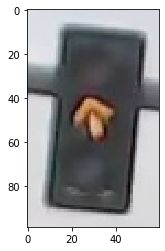

In [62]:
selected_image = IMAGE_LIST[740][0]
print("Shape of the image: ", str(selected_image.shape))
print("Label of the image: ", str(IMAGE_LIST[740][1]))
plt.imshow(selected_image)

# 2. Pre-process the Data

After loading all images, we need to pre-process image data first. In this study, we resize all training and test images into 32x32 pixel images.


In [15]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    ## TODO: Resize image and pre-process so that all "standard" images are the same size  
    standard_im = np.copy(image)
    resized_img = cv2.resize(standard_im, (32, 32))
    
    return resized_img
    

## Standardizing the output

With each loaded image, we also specify the expected output. For this, we use **one-hot encoding**.

* One-hot encode the labels. To do this, create an array of zeros representing each class of traffic light (red, yellow, green), and set the index of the expected class number to 1. 

In [16]:
# Examples: 
# one_hot_encode("red") should return: [1, 0, 0]
# one_hot_encode("yellow") should return: [0, 1, 0]
# one_hot_encode("green") should return: [0, 0, 1]

def one_hot_encode(label):
    if label == "red":
        one_hot_encoded = [1,0,0]
    elif label == "yellow":
        one_hot_encoded = [0,1,0]
    else:
        one_hot_encoded = [0,0,1]
    return one_hot_encoded

## Constructing standarized images

In [19]:
def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

## Visualizing the standardized data

Standarized image with label (left), non-standarized image with label (right)


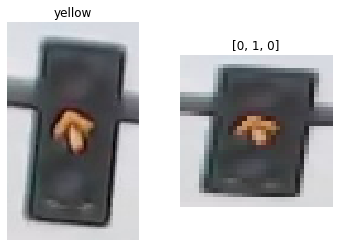

In [20]:
## TODO: Display a standardized image and its label
fig, axes = plt.subplots(1,2)
for ax in axes:
    ax.axis('off')
(ax0,ax1) = axes

ax0.imshow(IMAGE_LIST[740][0])
ax0.set_title(IMAGE_LIST[740][1])
ax1.imshow(STANDARDIZED_LIST[740][0])
ax1.set_title(STANDARDIZED_LIST[740][1])
print("Standarized image with label (left), non-standarized image with label (right)")

# 3. Feature Extraction

## RGB to HSV conversion

In order to extract features, we want to take all images into HSV domain from RGB. Then we want to create a musk using **S** space information. Once we have a musk, we can crop the musked part from the standarized RGB image.

Label [red, yellow, green]: [0, 1, 0]


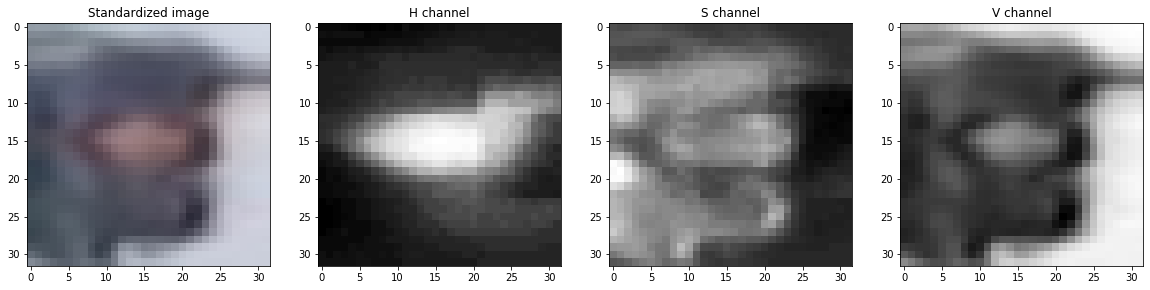

In [29]:
# Convert and image to HSV colorspace
# Visualize the individual color channels

image_num = 741
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

# Print image label
print('Label [red, yellow, green]: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Plot the original image and the three channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h, cmap='gray')
ax3.set_title('S channel')
ax3.imshow(s, cmap='gray')
ax4.set_title('V channel')
ax4.imshow(v, cmap='gray')


In [30]:
def musk(test_im):

    # Convert to HSV
    hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

    # HSV channels
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]

    change = np.copy(s)
    for i in range(0,len(s)):
        for j in range(0,len(s[i])):
            if(change[i][j] > 100):
                change[i][j] = 0
            else:
                change[i][j] = 1
    masked_image = np.copy(test_im)
    masked_image[change != 0] = [0, 0, 0]
    return masked_image

### Steps I followed for creating feature descriptor:
1. Created an image musk based on saturation and converted into gray image
2. Filtered lower pixel values from the musked image
3. Cropped the image with respect to vertical axis
4. Segmented the image into three sectors and took average of each sector
5. placed in a vector named "feature"

As I separated three different presumptive areas into red, yellow, and green sectors, my features should be able to describe if the image is red, yellow, or green.

In [31]:
def create_feature(rgb_image):
    musked_img = musk(rgb_image)
    img = cv2.cvtColor(musked_img, cv2.COLOR_RGB2GRAY )
    
    img[img < 110] = 0
    
    f_red = img[3:12,4:28]   # cropped presumptive red section
    f_yellow = img[13:19,4:28]
    f_green = img[20:28,4:28]
    
    feature_red = np.mean(f_red)      # mean pixel value from presumptive red area in the image
    feature_yellow = np.mean(f_yellow)
    feature_green = np.mean(f_green)
    
    feature = [feature_red,feature_yellow,feature_green]
    
    return feature

# Classification and Visualizing Error

In [32]:
# This function should take in RGB image input
# Analyze that image using your feature creation code and output a one-hot encoded label
def estimate_label(rgb_image):

    feature = create_feature(rgb_image)
    if feature[0] == max(feature):
        predicted_label = [1,0,0]
    elif feature[2] == max(feature):
        predicted_label = [0,0,1]
    else: 
        predicted_label = [0,1,0]
    
    return predicted_label   
    

## Testing the classifier

In [33]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

## Determine the Accuracy

In [34]:
def get_misclassified_images(test_images):
    misclassified_images_labels = []

    for image in test_images:
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        if(predicted_label != true_label):
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    return misclassified_images_labels

MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9023569023569024
Number of misclassified images = 29 out of 297


### Visualize the misclassified images

Shape: (32, 32, 3)
Label [red, yellow, green]: [1, 0, 0]


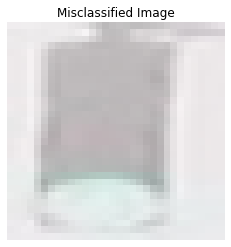

In [63]:
n = 27
miss_class_im = MISCLASSIFIED[n][0]
miss_class_lb = MISCLASSIFIED[n][1]

f, ax = plt.subplots(1)
ax.set_title('Misclassified Image')
ax.imshow(miss_class_im)
ax.axis('off')
print("Shape: " + str(miss_class_im.shape))
print("Label [red, yellow, green]: " + str(miss_class_lb))

# Traffic light classification using Convolutional Neural Network

In this part of the project, we implemented 3 layered convolutional neural network (CNN). 
1. We build 3 layer standard CNN model
2. We train the network
3. We test using test dataset
4. We find out accuracy (accurately classified images/total test images)

*Note: This convolutional neural network was made inspired by [](https://github.com/perseus784/BvS) 

### Setups:
1. python 3.7
2. tensorflow 1.14
3. keras 2.3.1
4. cuda 9.0
5. cudnn 7.6.5

### Data pre-processing:
Like previous part, we process data again. This time, we resize all images to 100x100 pixels.

### Neural network architecture:
A convolutional neural network architecture is shown below. We are giving a 100x100 pixel image as an input to the network and we have 3 output layers to classify red, green, or yellow images. 
<img src="images/conv.png" width="50%" height="50%">

In the cell below, we provide network architecture of our CNN 

In [1]:
from build_model import model_tools
import tensorflow as tf
model=model_tools()

def generate_model(images_ph,number_of_classes):
    #MODEL ARCHITECTURE:
    #level 1 convolution
    network=model.conv_layer(images_ph,5,3,16,1)
    network=model.pooling_layer(network,5,2)
    network=model.activation_layer(network)
    print(network)

    #level 2 convolution
    network=model.conv_layer(network,4,16,32,1)
    network=model.pooling_layer(network,4,2)
    network=model.activation_layer(network)
    print(network)

    #level 3 convolution
    network=model.conv_layer(network,3,32,64,1)
    network=model.pooling_layer(network,3,2)
    network=model.activation_layer(network)
    print(network)

    #flattening layer
    network,features=model.flattening_layer(network)
    print(network)

    #fully connected layer
    network=model.fully_connected_layer(network,features,1024)
    network=model.activation_layer(network)
    print(network)

    #output layer
    network=model.fully_connected_layer(network,1024,number_of_classes)
    print(network)
    return network


if __name__== "__main__":
    images_ph = tf.placeholder(tf.float32, shape=[None, 100,100,3])
    generate_model(images_ph,3)

C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-pack



Tensor("Relu:0", shape=(?, 50, 50, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 25, 25, 32), dtype=float32)
Tensor("Relu_2:0", shape=(?, 13, 13, 64), dtype=float32)
Tensor("Reshape:0", shape=(?, 10816), dtype=float32)
Tensor("Relu_3:0", shape=(?, 1024), dtype=float32)
Tensor("add_4:0", shape=(?, 3), dtype=float32)


C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Azam\Anaconda3\envs\tf-gp

### Building CNN model:
Now, we have model architecture. We want to build our CNN model in the next cell.

In [2]:
import tensorflow as tf


#model's unit definitions
class model_tools:
    # Defined functions for all the basic tensorflow components that we needed for building a model.
    # function definitions are in the respective comments

    def add_weights(self,shape):
        # a common method to create all sorts of weight connections
        # takes in shapes of previous and new layer as a list e.g. [2,10]
        # starts with random values of that shape.
        return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

    def add_biases(self,shape):
        # a common method to add create biases with default=0.05
        # takes in shape of the current layer e.g. x=10
        return tf.Variable(tf.constant(0.05, shape=shape))

    def conv_layer(self,layer, kernel, input_shape, output_shape, stride_size):
        #convolution occurs here.
        #create weights and biases for the given layer shape
        weights = self.add_weights([kernel, kernel, input_shape, output_shape])
        biases = self.add_biases([output_shape])
        #stride=[image_jump,row_jump,column_jump,color_jump]=[1,1,1,1] mostly
        stride = [1, stride_size, stride_size, 1]
        #does a convolution scan on the given image
        layer = tf.nn.conv2d(layer, weights, strides=stride, padding='SAME') + biases
        return layer

    def pooling_layer(self,layer, kernel_size, stride_size):
        # basically it reduces the complexity involved by only taking the important features alone
        # many types of pooling is there.. average pooling, max pooling..
        # max pooling takes the maximum of the given kernel
        #kernel=[image_jump,rows,columns,depth]
        kernel = [1, kernel_size, kernel_size, 1]
        #stride=[image_jump,row_jump,column_jump,color_jump]=[1,2,2,1] mostly
        stride = [1, stride_size, stride_size, 1]
        return tf.nn.max_pool(layer, ksize=kernel, strides=stride, padding='SAME')

    def flattening_layer(self,layer):
        #make it single dimensional
        input_size = layer.get_shape().as_list()
        new_size = input_size[-1] * input_size[-2] * input_size[-3]
        return tf.reshape(layer, [-1, new_size]),new_size

    def fully_connected_layer(self,layer, input_shape, output_shape):
        #create weights and biases for the given layer shape
        weights = self.add_weights([input_shape, output_shape])
        biases = self.add_biases([output_shape])
        #most important operation
        layer = tf.matmul(layer,weights) + biases  # mX+b
        return layer

    def activation_layer(self,layer):
        # we use Rectified linear unit Relu. it's the standard activation layer used.
        # there are also other layer like sigmoid,tanh..etc. but relu is more efficent.
        # function: 0 if x<0 else x.
        return tf.nn.relu(layer)

Once we have a CNN model ready, we can train our model. In order to do that, we need to provide some training parameters. The required training parameters are provided in the next cell.

In [3]:
import preprocessing as ppr
import os

#Parameters
raw_data='rawdata'
data_path='data'
height=100
width=100
if not os.path.exists(data_path):
    ppr.image_processing(raw_data,data_path,height,width)
all_classes = os.listdir(data_path)
number_of_classes = len(all_classes)
color_channels=3
epochs=2
batch_size=7
batch_counter=0
model_save_name='checkpoints'

## Training network: 
Now, we are all set for training our neural network model. The following cell includes code for training model.

In [4]:
import tensorflow as tf
import os
from utils import utils
from build_model import model_tools
import model_architecture
from tensorflow.python.client import device_lib
from config import *

tf.keras.backend.clear_session()

print(device_lib.list_local_devices())
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

session=tf.Session()
#create Placeholders for images and labels
images_ph=tf.placeholder(tf.float32,shape=[None,height,width,color_channels])
labels_ph=tf.placeholder(tf.float32,shape=[None,number_of_classes])

#training happens here
def trainer(network,number_of_images):
    #find error like squared error but better
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=network,labels=labels_ph)

    #now minize the above error
    #calculate the total mean of all the errors from all the nodes
    cost=tf.reduce_mean(cross_entropy)
    tf.summary.scalar("cost", cost)#for tensorboard visualisation

    #Now backpropagate to minimise the cost in the network.
    optimizer=tf.train.AdamOptimizer().minimize(cost)
    #print(optimizer)
    session.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(model_save_name, graph=tf.get_default_graph())
    merged = tf.summary.merge_all()
    saver = tf.train.Saver(max_to_keep=4)
    counter=0
    for epoch in range(epochs):
        tools = utils()
        for batch in range(int(number_of_images / batch_size)):
            counter+=1
            images, labels = tools.batch_dispatch()
            if images == None:
                break
            loss,summary = session.run([cost,merged], feed_dict={images_ph: images, labels_ph: labels})
            print('loss', loss)
            session.run(optimizer, feed_dict={images_ph: images, labels_ph: labels})

            print('Epoch number ', epoch, 'batch', batch, 'complete')
            writer.add_summary(summary,counter)
#        saver.save(session, os.path.join(model_save_name))
        saver.save(session, "./trained/trained_variables.ckpt")
#        saver.save(session, "./trained_variables.ckpt")

if __name__=="__main__":
    tools=utils()
    model=model_tools()
    network=model_architecture.generate_model(images_ph,number_of_classes)
    print (network)
    number_of_images = sum([len(files) for r, d, files in os.walk("data")])
    trainer(network,number_of_images)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5320032831593441793
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2337138278
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7140514907765312532
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Tensor("Relu:0", shape=(?, 50, 50, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 25, 25, 32), dtype=float32)
Tensor("Relu_2:0", shape=(?, 13, 13, 64), dtype=float32)
Tensor("Reshape:0", shape=(?, 10816), dtype=float32)
Tensor("Relu_3:0", shape=(?, 1024), dtype=float32)
Tensor("add_4:0", shape=(?, 3), dtype=float32)
Tensor("add_4:0", shape=(?, 3), dtype=float32)


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
	 [[Mean/_5]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Original stack trace for 'Conv2D':
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-cac65667adbb>", line 57, in <module>
    network=model_architecture.generate_model(images_ph,number_of_classes)
  File "C:\Users\Azam\Desktop\final_project_CV\model_architecture.py", line 8, in generate_model
    network=model.conv_layer(images_ph,5,3,16,1)
  File "C:\Users\Azam\Desktop\final_project_CV\build_model.py", line 28, in conv_layer
    layer = tf.nn.conv2d(layer, weights, strides=stride, padding='SAME') + biases
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1953, in conv2d
    name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


Now, we have trained mour model with red, green, and yellow traffic light dataset. We want to test with 297 test images that we have. The following two cells include codes for running test images. 

In [5]:
import numpy as np 
import cv2
import os
from call_network import call_net 

im_ph, label_ph, network, session = call_net()

path, dirs, files_red = next(os.walk('test/red'))
red_images = len(files_red)

path, dirs, files_yellow = next(os.walk('test/yellow'))
yellow_images = len(files_yellow)

path, dirs, files_green = next(os.walk('test/green'))
green_images = len(files_green)

image_numbers_by_color = [red_images, yellow_images, green_images]

folder_name = ['red', 'yellow', 'green']

correct_label = 0
missclass = 0
red_as_green = 0

for j in range(len(image_numbers_by_color)):
    individual_images = image_numbers_by_color[j]
    folder = folder_name[j]
    for i in range(individual_images):
        im=cv2.imread('test/' + str(folder) + '/' + str(i) + '.jpg')
                       
#        img=cv2.imread('./raw_traffic_light/traffic_light_images/test/red/0.jpg')
        
        im=cv2.resize(im,(100,100))
        img=im.reshape(1,100,100,3)
        
        labels = np.zeros((1, 3))
        
        # Creating the feed_dict that is required to be fed to calculate y_pred
        feed_dict_testing = {im_ph: img, label_ph: labels}
        result=session.run(network, feed_dict=feed_dict_testing)
        
        if folder == 'red' and result[0][1] == result.max():
            correct_label += 1
        elif folder == 'green' and result[0][0] == result.max():
            correct_label += 1
        elif folder == 'yellow' and result[0][2] == result.max():
            correct_label += 1
        else:
            missclass += 1
            # write all missclassified images in a folder to see what they look
            cv2.imwrite('test/misclassified/' + str(folder) + str(i) + '.jpg', im)
        
        # we never want a red signal classified as green. want to see how many red 
        # signals are classified as green
        if folder == 'red' and result[0][0] == result.max():
            red_as_green += 1

accuracy = correct_label/(correct_label+missclass)
print(accuracy)
print('number of missclassified images: ' + str(missclass) + ' out of ' + str(correct_label+missclass))
print('number of red signals classified as green: ' + str(red_as_green))



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from trained/trained_variables.ckpt



UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
	 [[Sigmoid/_67]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Original stack trace for 'Conv2D':
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-cac65667adbb>", line 57, in <module>
    network=model_architecture.generate_model(images_ph,number_of_classes)
  File "C:\Users\Azam\Desktop\final_project_CV\model_architecture.py", line 8, in generate_model
    network=model.conv_layer(images_ph,5,3,16,1)
  File "C:\Users\Azam\Desktop\final_project_CV\build_model.py", line 28, in conv_layer
    layer = tf.nn.conv2d(layer, weights, strides=stride, padding='SAME') + biases
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1953, in conv2d
    name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [6]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from build_model import model_tools

model=model_tools()
model_folder='checkpoints'
#image=sys.argv[1]
#img=cv2.imread(image)
#img=cv2.imread('raw_traffic_light/traffic_light_images/test/green/00febbe1-a9ae-4b5f-b682-8ebfdae485a3.jpg')
#img=cv2.imread('test_set/cats/cat.4001.jpg')
#img=cv2.imread('test_set/Boat/img_0.png')
img1=io.imread('test/red/10.jpg')
#img=cv2.imread('rawdata/superman/superman_00b89e7d-b40c-47ea-be96-8e9c0b7dcaf7.png')
session=tf.Session()
img=cv2.resize(img1,(100,100))
img=img.reshape(1,100,100,3)
labels = np.zeros((1, 3))

#Create a saver object to load the model
#saver = tf.train.import_meta_graph(os.path.join(model_folder,'.meta'))
saver = tf.train.import_meta_graph("trained/trained_variables.ckpt.meta")

#restore the model from our checkpoints folder

#Uncomment the following line for running on a windows machine
#saver.restore(session,os.path.join(model_folder,'.\\'))
saver.restore(session,"trained/trained_variables.ckpt")

#The following line is for running on a linux machine, comment it out if running on a windows machine
#saver.restore(session,os.path.join(model_folder,'./'))

#Create graph object for getting the same network architecture
graph = tf.get_default_graph()

#Get the last layer of the network by it's name which includes all the previous layers too
network = graph.get_tensor_by_name("add_4:0")

#create placeholders to pass the image and get output labels
im_ph= graph.get_tensor_by_name("Placeholder:0")
label_ph = graph.get_tensor_by_name("Placeholder_1:0")

#Inorder to make the output to be either 0 or 1.
network=tf.nn.sigmoid(network)

# Creating the feed_dict that is required to be fed to calculate y_pred
feed_dict_testing = {im_ph: img, label_ph: labels}
result=session.run(network, feed_dict=feed_dict_testing)

if result[0][0] == result.max():
    print('green')
    fig, ax = plt.subplots(figsize= (8,8))
    ax.imshow(img1)
    ax.set_title('Green test image')
    ax.text(0.2, 0.9, 'Green: ' + str(result.max()*100) + str('%'))
    ax.axis('off')
elif result[0][1] == result.max():
    print('red')
    fig, ax = plt.subplots(figsize= (8,8))
    ax.imshow(img1)
    ax.set_title('Red test image')
    ax.text(0.2, 0.9, 'Red: ' + str(result.max()*100) + str('%'))
    ax.axis('off')
else:
    print('yellow')
    fig, ax = plt.subplots(figsize= (8,8))
    ax.imshow(img1)
    ax.set_title('Yellow test image')
    ax.text(0.2, 0.9, 'Yellow: ' + str(result.max()*100) + str('%'))
    ax.axis('off')

INFO:tensorflow:Restoring parameters from trained/trained_variables.ckpt


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:28) ]]
	 [[Sigmoid_1/_67]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Input Source operations connected to node Conv2D:
 Placeholder (defined at <ipython-input-4-cac65667adbb>:16)	
 Variable/read (defined at C:\Users\Azam\Desktop\final_project_CV\build_model.py:13)

Original stack trace for 'Conv2D':
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-cac65667adbb>", line 57, in <module>
    network=model_architecture.generate_model(images_ph,number_of_classes)
  File "C:\Users\Azam\Desktop\final_project_CV\model_architecture.py", line 8, in generate_model
    network=model.conv_layer(images_ph,5,3,16,1)
  File "C:\Users\Azam\Desktop\final_project_CV\build_model.py", line 28, in conv_layer
    layer = tf.nn.conv2d(layer, weights, strides=stride, padding='SAME') + biases
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1953, in conv2d
    name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Azam\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


## Results:
We trained and tested CNN model in spyder. Unfortunately, CUDA and CUDNN is not working in jupyter for some reasons. So, we saved data from spyder and we provide some test images and performance here. We tested 297 test images in total of three different traffic light images. Accuracy is number of accurately classified image to total test images are given in the image below. 
<img src="images/Capture.JPG" width="70%" height="70%">

In 297 test images in total, we got 4 images misclassified. Those four imges are given below.

(-0.5, 99.5, 99.5, -0.5)

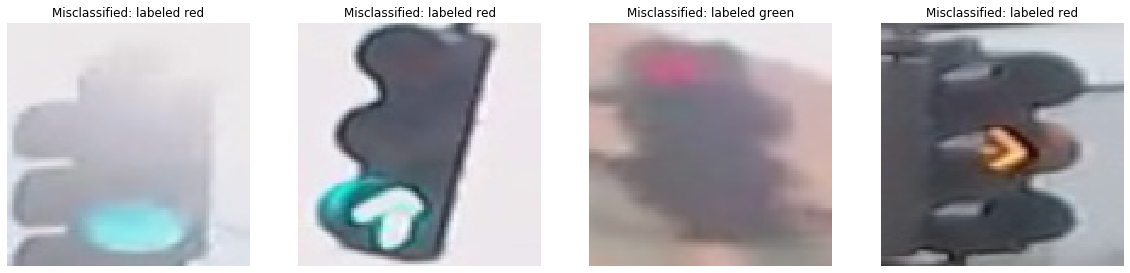

In [47]:
from skimage import io
mis1 = io.imread('test/misclassified/green55.jpg')
mis2 = io.imread('test/misclassified/green57.jpg')
mis3 = io.imread('test/misclassified/red19.jpg')
mis4 = io.imread('test/misclassified/yellow1.jpg')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Misclassified: labeled red')
ax1.imshow(mis1)
ax1.axis('off')
ax2.set_title('Misclassified: labeled red')
ax2.imshow(mis2)
ax2.axis('off')
ax3.set_title('Misclassified: labeled green')
ax3.imshow(mis3)
ax3.axis('off')
ax4.set_title('Misclassified: labeled red')
ax4.imshow(mis4)
ax4.axis('off')

### Discussion: 
We see that traffic light classification using CNN outperformed feature based classification used in this study. In feature based classification, we could manually tweak some parameters to make sure no red light is classified as green traffic light. But we are unavle to do so in the case of CNN. So, CNN classified 1 red traffic light as green. 

The third image from left was actualy a red signal. However, our CNN model labeled this image as green signal. This might result in devastating if we use this CNN trained model in practice. We never want a red signal as a green label. 

The potential solution to this misclassification might be as follows. In this study, we used community standard CNN model. Although theoretically we know that, while training a CNN model, loss should go down. In this study, I found that loss goes down as expected. But, suddenly after few epochs of training, loss goes up and gets stable there. The potential solution to this problem is using Residual Network (ResNet). In future, we will try ResNet to train and test traffic light. 

## Some tested images:

(-0.5, 799.5, 799.5, -0.5)

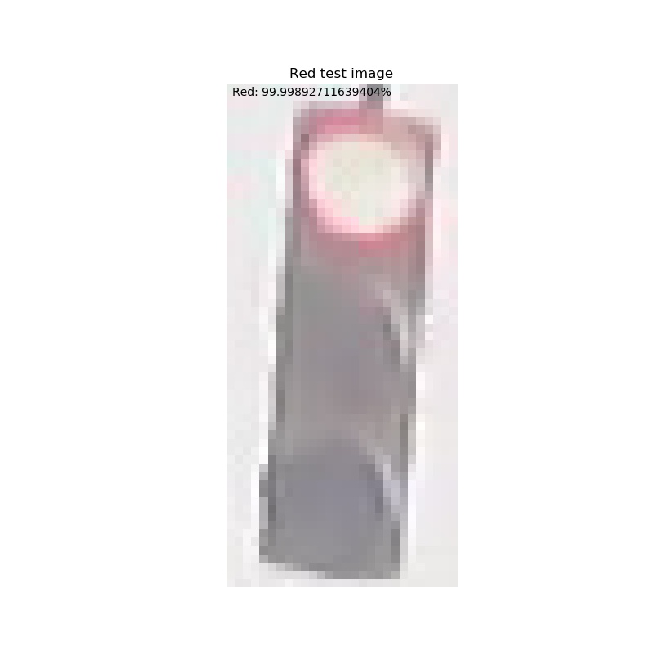

In [56]:
test1 = io.imread('tested_img/g1.jpg')

f, ax1 = plt.subplots(1, 1, figsize=(12,12))
ax1.imshow(test1)
ax1.axis('off')

(-0.5, 799.5, 799.5, -0.5)

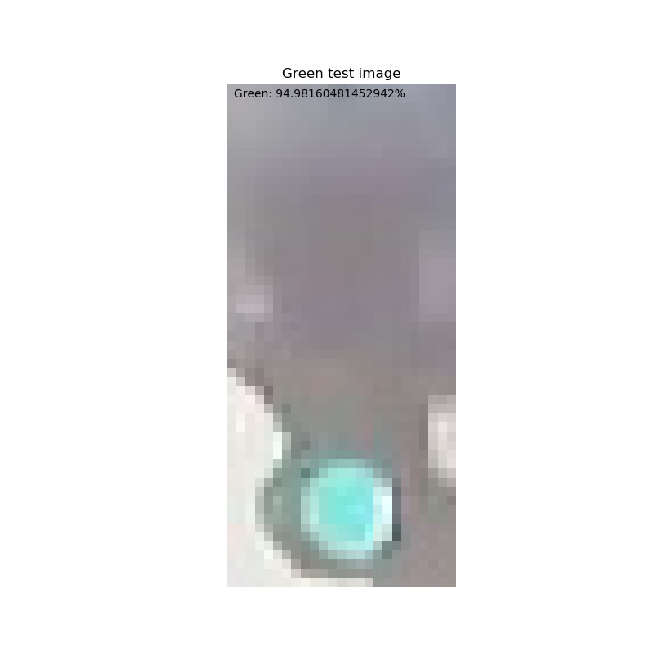

In [57]:
test1 = io.imread('tested_img/g13.jpg')

f, ax1 = plt.subplots(1, 1, figsize=(12,12))
ax1.imshow(test1)
ax1.axis('off')

(-0.5, 799.5, 799.5, -0.5)

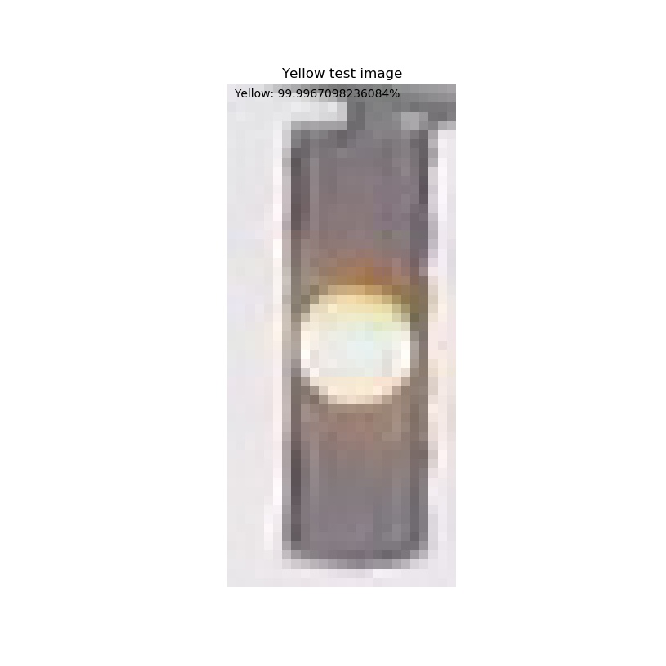

In [59]:
test1 = io.imread('tested_img/g21.jpg')

f, ax1 = plt.subplots(1, 1, figsize=(12,12))
ax1.imshow(test1)
ax1.axis('off')